In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import torch

In [2]:
df = pd.read_csv("Cleaned_Tickets.csv")
print(df.shape)
print(df.columns)
df.head()

(16337, 9)
Index(['subject', 'body', 'answer', 'type', 'department', 'priority', 'tag_1',
       'tag_2', 'tag_3'],
      dtype='object')


,subject,body,answer,type,department,priority,tag_1,tag_2,tag_3
0,Account Disruption,"Dear Customer Support Team, I am writing to re...",Thank you for reaching out. We are aware of th...,Incident,Technical Support,High,Account,Disruption,Outage
1,Query About Smart Home System Integration Feat...,"Dear Customer Support Team, I hope this messag...",Thank you for your inquiry. Our products suppo...,Request,Returns And Exchanges,Medium,Product,Feature,Tech Support
2,Inquiry Regarding Invoice Details,"Dear Customer Support Team, I hope this messag...",We appreciate you reaching out with your billi...,Request,Billing And Payments,Low,Billing,Payment,Account
3,Question About Marketing Agency Software Compa...,"Dear Support Team, I hope this message reaches...",Thank you for your inquiry. Our product suppor...,Problem,Sales And Pre-Sales,Medium,Product,Feature,Feedback
4,Feature Query,"Dear Customer Support, I hope this message rea...",Thank you for your inquiry. Please specify whi...,Request,Technical Support,High,Feature,Product,Documentation


In [4]:
print(df.isnull().sum())
df.dropna(subset = ['answer'],inplace = True)

subject       0
body          0
answer        0
type          0
department    0
priority      0
tag_1         0
tag_2         0
tag_3         0
dtype: int64


# Fine-tuned pretrained Transformer (DistilBERT)

In [7]:
import os, re, numpy as np, torch
os.environ["WANDB_DISABLED"] = "true"

from bs4 import BeautifulSoup
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

def clean_text(text):
    text = BeautifulSoup(str(text), "html.parser").get_text()
    return re.sub(r"[^a-z0-9\s]", "", text.lower()).strip()

df["input_text"] = (df["subject"].fillna("") + " " + df["body"].fillna("")).apply(clean_text)

le = LabelEncoder()
df["label"] = le.fit_transform(df["priority"])

# 80/10/10 split
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df["input_text"].tolist(),
    df["label"].tolist(),
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42
)

# Tokenize
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def encode(texts, labels):
    enc = tokenizer(texts, truncation=True, padding=True, return_tensors="pt")
    enc["labels"] = torch.tensor(labels, dtype=torch.long)
    return enc

train_enc = encode(train_texts, train_labels)
val_enc   = encode(val_texts, val_labels)
test_enc  = encode(test_texts, test_labels)


class DictDataset(torch.utils.data.Dataset):
    def __init__(self, enc_dict):
        self.enc = enc_dict
        self.n = self.enc["input_ids"].size(0)
    def __len__(self): return self.n
    def __getitem__(self, idx):
        return {k: v[idx] for k,v in self.enc.items()}

train_ds = DictDataset(train_enc)
val_ds   = DictDataset(val_enc)
test_ds  = DictDataset(test_enc)

BATCH_SIZE = 8
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

#  Model, Optimizer, Scheduler
num_labels = len(le.classes_)
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=num_labels
).to(device)

LEARNING_RATE = 2e-5
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=1)

# Train/Eval helpers
def train_epoch(model, loader):
    model.train()
    total_loss, total_correct, total_examples = 0.0, 0, 0
    for batch in loader:
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=-1)
        total_correct += (preds == labels).sum().item()
        total_examples += labels.size(0)

    return total_loss / total_examples, total_correct / total_examples

def eval_model(model, loader):
    model.eval()
    total_loss, total_examples = 0.0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids      = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels         = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss, logits = outputs.loss, outputs.logits

            total_loss += loss.item() * labels.size(0)
            total_examples += labels.size(0)

            all_preds.append(logits.argmax(dim=-1).cpu())
            all_labels.append(labels.cpu())

    avg_loss = total_loss / total_examples
    y_true = torch.cat(all_labels).numpy()
    y_pred = torch.cat(all_preds).numpy()
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0, target_names=le.classes_)
    return avg_loss, report

# Training loop
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_f1 = -1
patience = 3
epochs_since_improvement = 0
num_epochs = 50
checkpoint_path = "best_priority_model.pt"

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_epoch(model, train_loader)
    val_loss, val_report  = eval_model(model, val_loader)

    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_report["accuracy"])

    f1    = val_report["weighted avg"]["f1-score"]
    prec  = val_report["weighted avg"]["precision"]
    recall= val_report["weighted avg"]["recall"]

    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Epoch {epoch:02d}: new best F1={best_f1:.4f}, saved checkpoint.")
        epochs_since_improvement = 0
    else:
        epochs_since_improvement += 1

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} "
          f"| F1: {f1:.4f} | Prec: {prec:.4f} | Recall: {recall:.4f}")

    if epochs_since_improvement >= patience:
        print(f"Stopping early at epoch {epoch}.")
        break

# Artifacts
os.makedirs("./priority_model_artifacts", exist_ok=True)
torch.save(model.state_dict(), "./priority_model_artifacts/last_epoch.pt")
import joblib
joblib.dump(le, "./priority_model_artifacts/label_encoder.joblib")
print("Saved model + label encoder.")

# Test Evaluation
best_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=num_labels
).to(device)
best_model.load_state_dict(torch.load(checkpoint_path))

test_loss, test_report = eval_model(best_model, test_loader)

print("\n===== TEST RESULTS =====")
print(f"Test Loss: {test_loss:.4f}")
print(f"Accuracy: {test_report['accuracy']:.4f}")
print(f"Precision (weighted): {test_report['weighted avg']['precision']:.4f}")
print(f"Recall (weighted):    {test_report['weighted avg']['recall']:.4f}")
print(f"F1-score (weighted):  {test_report['weighted avg']['f1-score']:.4f}")

print("\nPer-class results:")
for label, metrics in test_report.items():
    if label in le.classes_:
        print(f"{label}: Precision={metrics['precision']:.4f}, Recall={metrics['recall']:.4f}, F1={metrics['f1-score']:.4f}")


Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 01: new best F1=0.4276, saved checkpoint.
Epoch 01 | Train Loss: 1.0232 | Val Loss: 1.0002 | F1: 0.4276 | Prec: 0.3844 | Recall: 0.4825
Epoch 02: new best F1=0.5192, saved checkpoint.
Epoch 02 | Train Loss: 0.9295 | Val Loss: 0.9506 | F1: 0.5192 | Prec: 0.5325 | Recall: 0.5346
Epoch 03: new best F1=0.5987, saved checkpoint.
Epoch 03 | Train Loss: 0.7515 | Val Loss: 0.8707 | F1: 0.5987 | Prec: 0.6133 | Recall: 0.6148
Epoch 04: new best F1=0.6461, saved checkpoint.
Epoch 04 | Train Loss: 0.5225 | Val Loss: 0.9024 | F1: 0.6461 | Prec: 0.6517 | Recall: 0.6516
Epoch 05: new best F1=0.6660, saved checkpoint.
Epoch 05 | Train Loss: 0.3527 | Val Loss: 0.9731 | F1: 0.6660 | Prec: 0.6788 | Recall: 0.6730
Epoch 06: new best F1=0.6960, saved checkpoint.
Epoch 06 | Train Loss: 0.1708 | Val Loss: 1.0403 | F1: 0.6960 | Prec: 0.7062 | Recall: 0.6987
Epoch 07: new best F1=0.7101, saved checkpoint.
Epoch 07 | Train Loss: 0.1172 | Val Loss: 1.0812 | F1: 0.7101 | Prec: 0.7131 | Recall: 0.7128
Epoch 

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



===== TEST RESULTS =====
Test Loss: 1.5350
Accuracy: 0.7307
Precision (weighted): 0.7370
Recall (weighted):    0.7307
F1-score (weighted):  0.7287

Per-class results:
High: Precision=0.7872, Recall=0.7748, F1=0.7810
Low: Precision=0.7695, Recall=0.5549, F1=0.6448
Medium: Precision=0.6723, Recall=0.7779, F1=0.7213


#  Baseline model (FastText)

In [8]:
import re, torch
import numpy as np
from collections import Counter
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


texts  = (df["subject"].fillna("") + " " + df["body"].fillna("")).tolist()
labels = le.fit_transform(df["priority"])

# 80/10/10 split
X_tr, X_tmp, y_tr, y_tmp = train_test_split(
    texts, labels, test_size=0.20, stratify=labels, random_state=42
)
X_val, X_te, y_val, y_te = train_test_split(
    X_tmp, y_tmp, test_size=0.50, stratify=y_tmp, random_state=42
)
print(f"train={len(X_tr)}  val={len(X_val)}  test={len(X_te)}")

def clean(s):
    s = str(s).lower()
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    return re.sub(r"\s+", " ", s).strip()

def tok(s):
    return clean(s).split()

train_tokens = [tok(t) for t in X_tr]
counter = Counter(w for sent in train_tokens for w in sent)

vocab = {"<pad>": 0, "<unk>": 1}
for i, (w, _) in enumerate(counter.most_common(50000), start=2):
    vocab[w] = i

def encode(tokens, max_len=128):
    ids = [vocab.get(w, 1) for w in tokens][:max_len]
    if len(ids) < max_len:
        ids += [0] * (max_len - len(ids))
    return ids

class TxtDS(Dataset):
    def __init__(self, texts, labels, max_len=128):
        self.x = [encode(tok(t), max_len) for t in texts]
        self.y = np.array(labels, dtype=np.int64)
    def __len__(self): return len(self.y)
    def __getitem__(self, i):
        return torch.tensor(self.x[i]), torch.tensor(self.y[i])

max_len = 128
tr_ds  = TxtDS(X_tr,  y_tr,  max_len)
val_ds = TxtDS(X_val, y_val, max_len)
te_ds  = TxtDS(X_te,  y_te,  max_len)

tr_dl  = DataLoader(tr_ds,  batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)
te_dl  = DataLoader(te_ds,  batch_size=64, shuffle=False)

# model
class FastTextLike(nn.Module):
    def __init__(self, vocab_size, num_labels, emb_dim=128, dropout=0.2):
        super().__init__()
        self.emb  = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.drop = nn.Dropout(dropout)
        self.fc   = nn.Linear(emb_dim, num_labels)
    def forward(self, x):
        e = self.emb(x)
        m = e.mean(dim=1)
        m = self.drop(m)
        return self.fc(m)

num_labels = len(le.classes_)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = FastTextLike(len(vocab), num_labels).to(device)

opt  = torch.optim.AdamW(net.parameters(), lr=3e-3)
crit = nn.CrossEntropyLoss()

best_f1, patience, no_improve = -1.0, 3, 0
for epoch in range(1, 30 + 1):
    net.train()
    tot, correct, n = 0.0, 0, 0
    for xb, yb in tr_dl:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        logits = net(xb)
        loss = crit(logits, yb)
        loss.backward()
        opt.step()
        tot += loss.item() * yb.size(0)
        correct += (logits.argmax(1) == yb).sum().item()
        n += yb.size(0)
    train_loss, train_acc = tot / n, correct / n

    # --- validation on 10% ---
    net.eval()
    all_p, all_y = [], []
    with torch.no_grad():
        for xb, yb in val_dl:
            logits = net(xb.to(device))
            all_p.append(logits.argmax(1).cpu())
            all_y.append(yb)
    yp = torch.cat(all_p).numpy()
    yt = torch.cat(all_y).numpy()
    report = classification_report(yt, yp, output_dict=True, zero_division=0)
    f1 = report["weighted avg"]["f1-score"]

    print(f"epoch {epoch:02d} | train_loss {train_loss:.4f} acc {train_acc:.3f} | val_f1 {f1:.3f}")

    if f1 > best_f1:
        best_f1, no_improve = f1, 0
        torch.save(net.state_dict(), "fasttext_best.pt")
    else:
        no_improve += 1
        if no_improve >= patience:
            print("early stop."); break

# TEST report
net.load_state_dict(torch.load("fasttext_best.pt", map_location=device))
net.eval()
all_p, all_y = [], []
with torch.no_grad():
    for xb, yb in te_dl:
        logits = net(xb.to(device))
        all_p.append(logits.argmax(1).cpu())
        all_y.append(yb)

yp = torch.cat(all_p).numpy()
yt = torch.cat(all_y).numpy()
print("\n=== TEST SET REPORT (final checkpoint) ===")
print(classification_report(yt, yp, target_names=list(le.classes_), zero_division=0))

train=13067  val=1633  test=1634
epoch 01 | train_loss 1.0538 acc 0.441 | val_f1 0.412
epoch 02 | train_loss 1.0079 acc 0.488 | val_f1 0.441
epoch 03 | train_loss 0.9561 acc 0.525 | val_f1 0.484
epoch 04 | train_loss 0.9034 acc 0.565 | val_f1 0.498
epoch 05 | train_loss 0.8617 acc 0.599 | val_f1 0.513
epoch 06 | train_loss 0.8241 acc 0.624 | val_f1 0.515
epoch 07 | train_loss 0.7909 acc 0.640 | val_f1 0.529
epoch 08 | train_loss 0.7659 acc 0.655 | val_f1 0.533
epoch 09 | train_loss 0.7448 acc 0.670 | val_f1 0.540
epoch 10 | train_loss 0.7256 acc 0.680 | val_f1 0.546
epoch 11 | train_loss 0.7062 acc 0.686 | val_f1 0.549
epoch 12 | train_loss 0.6906 acc 0.697 | val_f1 0.556
epoch 13 | train_loss 0.6780 acc 0.701 | val_f1 0.558
epoch 14 | train_loss 0.6646 acc 0.709 | val_f1 0.573
epoch 15 | train_loss 0.6529 acc 0.717 | val_f1 0.561
epoch 16 | train_loss 0.6418 acc 0.721 | val_f1 0.571
epoch 17 | train_loss 0.6336 acc 0.726 | val_f1 0.577
epoch 18 | train_loss 0.6200 acc 0.733 | val_f1 0

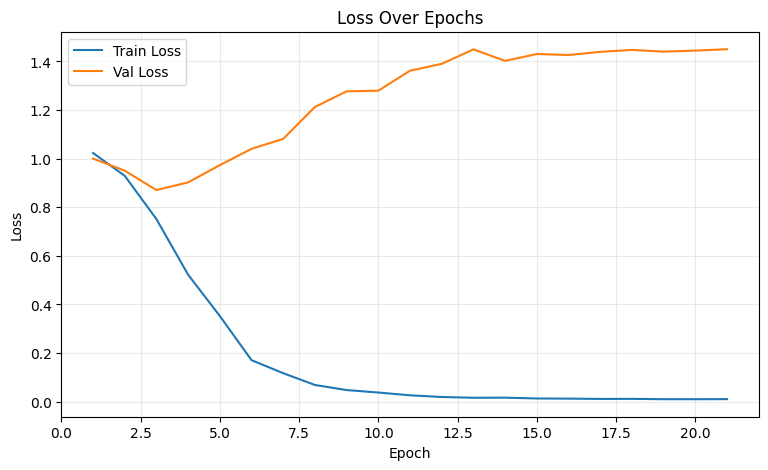

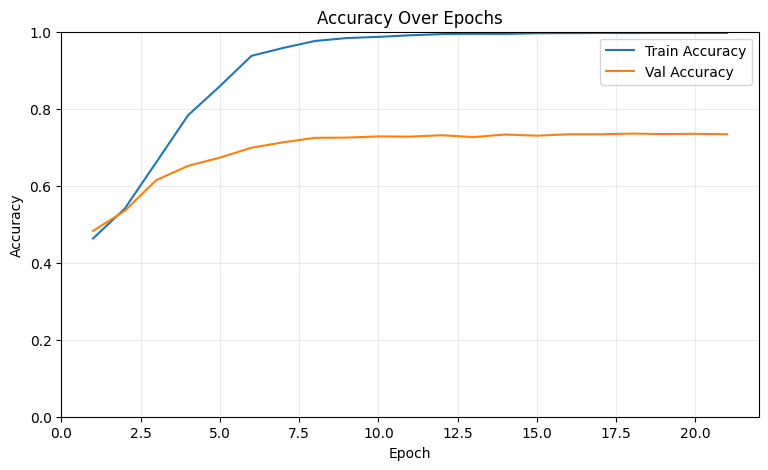

In [9]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

# --- Figure 1: Loss Over Epochs ---
plt.figure(figsize=(9,5))
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses,   label="Val Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.grid(True, alpha=0.25)
plt.show()

# --- Figure 2: Accuracy Over Epochs ---
plt.figure(figsize=(9,5))
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies,   label="Val Accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.ylim(0, 1.0)
plt.legend(); plt.grid(True, alpha=0.25)
plt.show()
